# This notebook demos the use of the GNP package for solving Ax = b

In [1]:
import os
import time
import torch
import argparse
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from GNP.problems import *
from GNP.solver import GMRES
from GNP.precond import *
from GNP.nn import ResGCN
from GNP.utils import scale_A_by_spectral_radius, load_suitesparse

Set computing device and number of dataloader workers

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    num_workers = 4
else:
    device = torch.device('cpu')
    num_workers = 0

Load matrix and generate right-hand side

In [4]:
location = '~/data/SuiteSparse/ssget/mat'
problem = 'VanVelzen/std1_Jac3'
A = load_suitesparse(location, problem, device)

# Normalize A to avoid hassles
A = scale_A_by_spectral_radius(A)

# Generate right-hand side b
n = A.shape[0]
x = gen_x_all_ones(n).to(device)
b = A @ x
del x
    
# Print problem information
print(f'Matrix A: name = {problem}, n = {n}, nnz = {A._nnz()}')

/home/skunk/miniconda3/envs/gnp/lib/python3.12/site-packages/GNP/utils.py:32: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(A.indptr, A.indices, A.data, A.shape,


Matrix A: name = VanVelzen/std1_Jac3, n = 21982, nnz = 1455374


Set up output location and file names

In [5]:
out_path = os.path.abspath(os.path.expanduser('./dump'))
Path(out_path).mkdir(parents=True, exist_ok=True)
out_file_prefix_with_path = os.path.join(out_path, 'VanVelzen_std1_Jac3_')

Set the linear solver and parameters

In [6]:
solver = GMRES()
restart = 10                # restart cycle in GMRES
max_iters = 100             # maximum number of GMRES iterations
timeout = None              # timeout in seconds
rtol = 1e-8                 # relative residual tolerance in GMRES

## Solve without preconditioner

In [7]:
print('Solving linear system without preconditioner ...')

# Dry run; timing is not accurate
solver.solve(A, b, M=None, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=False)

# Actual run
_, _, _, hist_rel_res, hist_time = \
    solver.solve(A, b, M=None, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=True)

print(f'Done. Final relative residual = {hist_rel_res[-1]:.4e}')

Solving linear system without preconditioner ...


Solve: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.85it/s]

Done. Final relative residual = 5.9049e-01


## Solve with GNP

Set network and training parameters

In [8]:
num_layers = 8              # number of layers in GNP
embed = 16                  # embedding dimension in GNP
hidden = 32                 # hidden dimension in MLPs in GNP
drop_rate = 0.0             # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float32       # training precision for GNP
lr = 1e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 40                      # Krylov subspace dimension for training data
batch_size = 16             # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 2000               # number of epochs in training GNP

Train preconditioner

In [9]:
print('Training GNP ...')

net = ResGCN(A, num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=num_workers,
    checkpoint_prefix_with_path=out_file_prefix_with_path, progress_bar=True)

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
print(f'Best model saved in {model_file}')

Training GNP ...


Train loss 1.4e-03: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.01it/s]

Done. Training time: 100.08854961395264 seconds
Loss: inital = 0.0014289922546595335, final = 0.0013724409509450197, best = 0.001121627981774509, epoch = 1340
Best model saved in /home/skunk/GNP/examples/dump/VanVelzen_std1_Jac3_epoch_1340.pt


Investigate training history. Interestingly, the training loss is sufficiently small at the beginning, even though the training curve does not look normal.

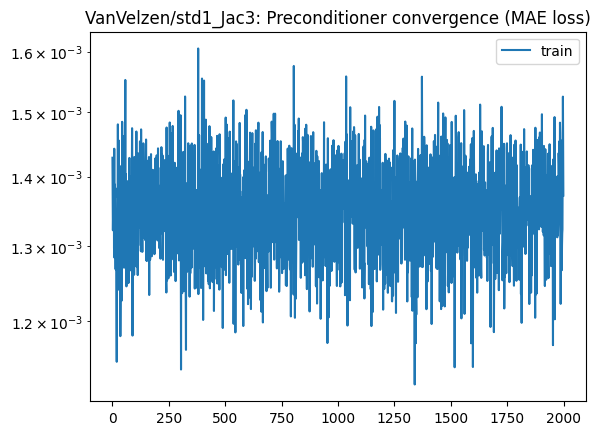

In [10]:
plt.semilogy(hist_loss, label='train')
plt.title(f'{problem}: Preconditioner convergence (MAE loss)')
plt.legend()
# full_path = out_file_prefix_with_path + 'training.png'
# plt.savefig(full_path)
# print(f'Figure saved in {full_path}')

Load the best checkpoint

In [11]:
print(f'Loading model from {model_file} ...')
net.load_state_dict(torch.load(model_file, map_location=device, weights_only=True))
M = GNP(A, training_data, m, net, device)
print('Done.')

Loading model from /home/skunk/GNP/examples/dump/VanVelzen_std1_Jac3_epoch_1340.pt ...
Done.


Solve linear system with the trained preconditioner

In [12]:
print('Solving linear system with GNP ...')
warnings.filterwarnings('error')
try:
    _, _, _, hist_rel_res_gnp, hist_time_gnp = \
        solver.solve(A, b, M=M, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=True)
except UserWarning as w:
    print('Warning:', w)
    print('GMRES preconditioned by GNP fails')
    hist_rel_res_gnp = None
    hist_time_gnp = None
else:
    print(f'Done. Final relative residual = {hist_rel_res_gnp[-1]:.4e}')
warnings.resetwarnings()

Solving linear system with GNP ...


Solve: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.41it/s]

Done. Final relative residual = 6.5576e-08


## Solve with GMRES as a preconditioner (i.e., inner-outer GMRES)

Set preconditioner parameters

In [13]:
inner_iters = 10            # number of GMRES iterations as preconditioner
inner_rtol = 1e-6           # relative residual tolerance in inner GMRES solve

Solve

In [14]:
print('Solving linear system with GMRES preconditioner (FGMRES) ...')
M = GMRESPreconditioner(A, inner_iters=inner_iters, inner_rtol=inner_rtol)
_, _, _, hist_rel_res_fgmres, hist_time_fgmres = \
    solver.solve(A, b, M=M, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=True)
print(f'Done. Final relative residual = {hist_rel_res_fgmres[-1]:.4e}')

Solving linear system with GMRES preconditioner (FGMRES) ...


Solve: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.20it/s]

Done. Final relative residual = 3.1474e-01


## Solve with ILU

In [15]:
print('Solving linear system with ILU preconditioner ...')
tic = time.time()
try:
    # Perform ILU factorization; may fail
    full_path = out_file_prefix_with_path + 'ilu.pkl'
    M = ILU(A, full_path, True)
except RuntimeError as e:
    print('RuntimeError:', e)
    print('Fail to perform ILU factorization')
    hist_rel_res_ilu = None
    hist_time_ilu = None
else:
    print(f'ILU factorization time: {time.time()-tic} seconds')
    print(f'ILU factors saved in {full_path}')
    _, _, _, hist_rel_res_ilu, hist_time_ilu = \
        solver.solve(A, b, M=M, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=True)
    print(f'Done. Final relative residual = {hist_rel_res_ilu[-1]:.4e}')

Solving linear system with ILU preconditioner ...
RuntimeError: Factor is exactly singular
Fail to perform ILU factorization


## Solve with AMG

In [16]:
print('Solving linear system with AMG preconditioner ...')
try:
    tic = time.time()
    # Set up AMG; may fail
    M = AMGPreconditioner(A)
except TypeError as e:
    print('TypeError:', e)
    print('Fail to construct AMG preconditioner')
    hist_rel_res_amg = None
    hist_time_amg = None
else:
    print(f'AMG construction time: {time.time()-tic} seconds')
    _, _, _, hist_rel_res_amg, hist_time_amg = \
        solver.solve(A, b, M=M, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=True)
    print(f'Done. Final relative residual = {hist_rel_res_amg[-1]:.4e}')

Solving linear system with AMG preconditioner ...
AMG construction time: 0.3287065029144287 seconds


Solve: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.90it/s]

Done. Final relative residual = 1.5617e-02


## Solve with Jacobi

In [17]:
print('Solving linear system with Jacobi preconditioner ...')
M = Jacobi(A)
_, _, _, hist_rel_res_jacobi, hist_time_jacobi = \
    solver.solve(A, b, M=M, restart=restart, max_iters=max_iters, timeout=timeout, rtol=rtol, progress_bar=True)
print(f'Done. Final relative residual = {hist_rel_res_jacobi[-1]:.4e}')

Solving linear system with Jacobi preconditioner ...


Solve: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 425.81it/s]

Done. Final relative residual = 6.6433e-01


## Investigate all solves

Plotting solution history ...


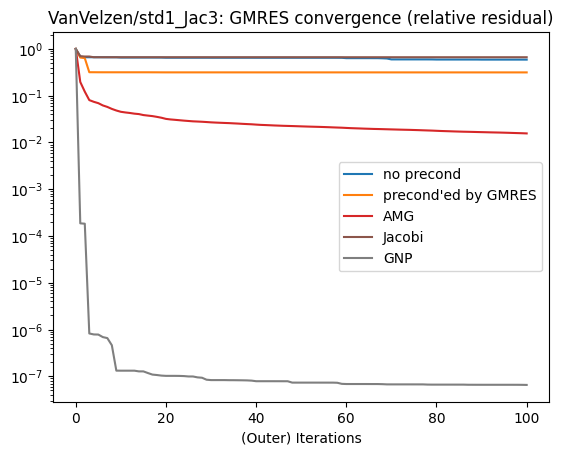

In [18]:
print('Plotting solution history ...')
plt.semilogy(hist_rel_res, color='C0', label='no precond')
plt.semilogy(hist_rel_res_fgmres, color='C1', label="precond'ed by GMRES")
if hist_rel_res_ilu is not None:
    plt.semilogy(hist_rel_res_ilu, color='C2', label='ILU')
if hist_rel_res_amg is not None:
    plt.semilogy(hist_rel_res_amg, color='C3', label='AMG')
if hist_rel_res_jacobi is not None:
    plt.semilogy(hist_rel_res_jacobi, color='C5', label='Jacobi')
if hist_rel_res_gnp is not None:
    plt.semilogy(hist_rel_res_gnp, color='C7', label='GNP')
plt.title(f'{problem}: GMRES convergence (relative residual)')
plt.xlabel('(Outer) Iterations')
plt.legend()
# full_path = out_file_prefix_with_path + 'solver.png'
# plt.savefig(full_path)
# print(f'Figure saved in {full_path}')

Plotting solution history (time to solution) ...


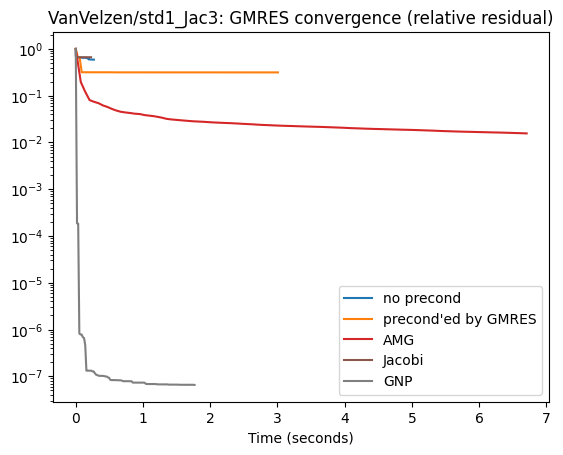

In [19]:
print('Plotting solution history (time to solution) ...')
plt.semilogy(hist_time, hist_rel_res, color='C0', label='no precond')
plt.semilogy(hist_time_fgmres, hist_rel_res_fgmres, color='C1', label="precond'ed by GMRES")
if hist_rel_res_ilu is not None:
    plt.semilogy(hist_time_ilu, hist_rel_res_ilu, color='C2', label='ILU')
if hist_rel_res_amg is not None:
    plt.semilogy(hist_time_amg, hist_rel_res_amg, color='C3', label='AMG')
if hist_rel_res_jacobi is not None:
    plt.semilogy(hist_time_jacobi, hist_rel_res_jacobi, color='C5', label='Jacobi')
if hist_rel_res_gnp is not None:
    plt.semilogy(hist_time_gnp, hist_rel_res_gnp, color='C7', label='GNP')
plt.title(f'{problem}: GMRES convergence (relative residual)')
plt.xlabel('Time (seconds)')
plt.legend()
# full_path = out_file_prefix_with_path + 'time.png'
# plt.savefig(full_path)
# print(f'Figure saved in {full_path}')